In [3]:
# 주석 발췌 : "미술관에 GAN 딥러닝 실전 프로젝트 (Generative Deep Learning)"
#             "케라스 창시자에게 배우는 딥러닝"
# 코드 참고 : https://github.com/lyeoni/keras-mnist-VAE/blob/master/keras-mnist-VAE.ipynb

from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.datasets import mnist

In [4]:
# mnist data loading

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)

print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [5]:
# encoder build

latent_dim = 2

x = Input(shape=(x_train.shape[1:]))
x_encoded = Dense(256, activation = 'relu')(x)
x_encoded = Dense(128, activation = 'relu')(x_encoded)

mu = Dense(latent_dim)(x_encoded)       # 분포의 평균 벡터
log_var = Dense(latent_dim)(x_encoded)  #  차원별 분산의 값

# 인코더는 입력 이미지를 받아 잠재 공간의 다변수 정규 분포를 정의하는
# 2개의 벡터 mu와 log_var로 인코딩 한다.

encoder_model = Model(x, mu)
encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


In [6]:
# sampling function

def sampling(args):
    mu, log_var = args
    
    # batch size = 100, dim = 2
    epsilon = K.random_normal(shape=(100, 2), mean=0., stddev=1.0)   
    # epsilon은 표준 정규 분포에서 샘플링 된 값
    # mu에서 얼마나 떨어져 표시해야 하는지를 나타냄
    
    return mu + K.exp(log_var) * epsilon

In [7]:
z = Lambda(sampling, output_shape=(2,))([mu, log_var])

In [8]:
# decoder build
# 중복 사용하는 네트워크 - 동일한 가중치 값을 가지도록 갱신해여ㅑ 하므로,
# 별도로 정의해놓고 호출하는 방식으로 작성 (220819)
# Keras 함수형 API의 구조에 대한 이해가 부족해 이부분을 수정하는데 시간 소요(220819)

z_decoder1 = Dense(256, activation='relu')
z_decoder2 = Dense(128, activation='relu')
y_decoder = Dense(x_train.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

decoder_input = Input(shape = (2,))
z_decoded_1 = z_decoder1(decoder_input)
z_decoded_1 = z_decoder2(z_decoded_1)
y_1 = y_decoder(z_decoded_1)

In [9]:
# decoder build

generator_model = Model(decoder_input, y_1)
generator_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              multiple                  768       
_________________________________________________________________
dense_5 (Dense)              multiple                  32896     
_________________________________________________________________
dense_6 (Dense)              multiple                  101136    
Total params: 134,800
Trainable params: 134,800
Non-trainable params: 0
_________________________________________________________________


In [10]:
# loss

# Reconstrution Loss : x와 생성된 x 관계에서 손실
# Regularization Loss : x가 원래 가지는 분포와 동일한 분포를 가지도록 
#                       true 분포와 approximation 분포의 관계

reconstruction_loss = losses.binary_crossentropy(x, y)*x_train.shape[1]
kl_loss = 0.5*K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis=-1)

vae_loss = reconstruction_loss + kl_loss

In [11]:
# VAE trainable model

vae_model = Model(x, y)
vae_model.add_loss(vae_loss)
vae_model.compile(optimizer='rmsprop')
vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
____________________________________________________________________________________________

In [12]:
# VAE model train

vae_model.fit(x_train, shuffle=True,
             epochs=30, batch_size=100,
             validation_data=(x_test, None), verbose=1)

vae_model.save_weights('vae_model_weight.h5')

Epoch 1/30
600/600 [==============================] - 2s 3ms/step - loss: 216.6412 - val_loss: 166.3022
Epoch 2/30
600/600 [==============================] - 2s 3ms/step - loss: 164.7390 - val_loss: 158.8552
Epoch 3/30
600/600 [==============================] - 2s 3ms/step - loss: 157.7600 - val_loss: 155.0908
Epoch 4/30
600/600 [==============================] - 2s 3ms/step - loss: 154.4160 - val_loss: 152.6853
Epoch 5/30
600/600 [==============================] - 2s 3ms/step - loss: 152.2799 - val_loss: 150.5773
Epoch 6/30
600/600 [==============================] - 2s 3ms/step - loss: 150.2926 - val_loss: 149.3980
Epoch 7/30
600/600 [==============================] - 2s 3ms/step - loss: 148.8868 - val_loss: 148.7249
Epoch 8/30
600/600 [==============================] - 2s 3ms/step - loss: 147.6662 - val_loss: 147.5549
Epoch 9/30
600/600 [==============================] - 2s 3ms/step - loss: 146.6273 - val_loss: 146.0682
Epoch 10/30
600/600 [==============================] - 2s 3ms/st

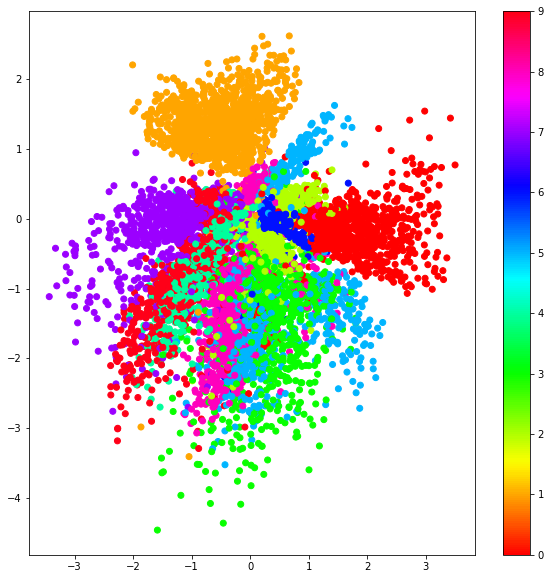

In [15]:
# plot latent space

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

x_test_latent = encoder_model.predict(x_test, batch_size=100)
plt.figure(figsize=(10,10))
plt.scatter(x_test_latent[:,0], x_test_latent[:,1], c=y_test, cmap='hsv')
# c는 y_test의 항목으로 0, 1, 2, ... , 9로 colorbar 구분 표시
plt.colorbar()
plt.show()

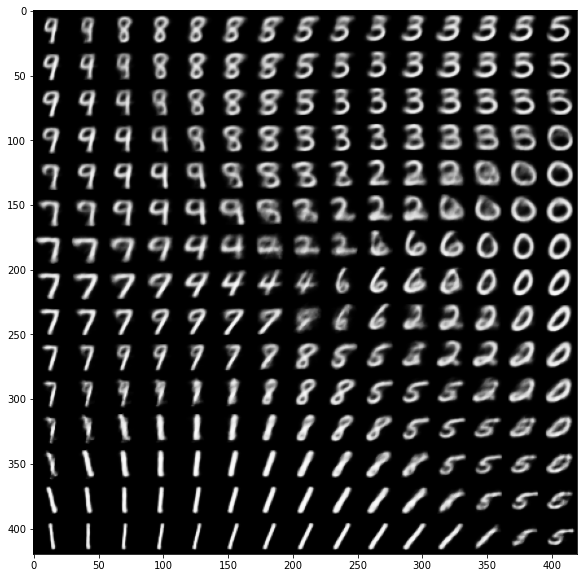

In [16]:
# display a 2D manifold, figure with 15 x 15 digit

n =15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator_model.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, 
              j * digit_size: (j + 1) * digit_size] = digit
        
plt.figure(figsize=(10,10))
plt.imshow(figure, cmap='Greys_r')
plt.show() 

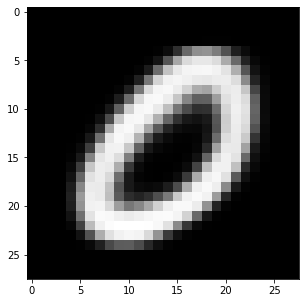

In [19]:
# 임의의 latent 값을 입력하여 숫자 하나를 생성 (220819)

z_sample = np.array([[2.0, 0.]])  # 결과 0

x_decoded = generator_model.predict(z_sample)
digit = x_decoded[0].reshape(28, 28)
figure = digit
plt.figure(figsize=(5, 5))
plt.imshow(figure, cmap='Greys_r')
plt.show() 

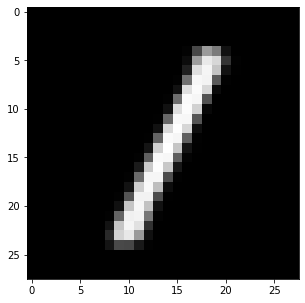

In [20]:
# 임의의 latent 값을 입력하여 숫자 하나를 생성 (220819)

z_sample = np.array([[0., 2.]])  # 결과 1

x_decoded = generator_model.predict(z_sample)
digit = x_decoded[0].reshape(28, 28)
figure = digit
plt.figure(figsize=(5, 5))
plt.imshow(figure, cmap='Greys_r')
plt.show() 